In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2022-10-10 20:14:53.025270
Simons Foundation, Rusty HPC, worker3042


In [2]:
%cd /mnt/home/zzhang/ceph/CHARM-AlternativeSplicing

/mnt/ceph/users/zzhang/CHARM-AlternativeSplicing


In [3]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import scipy.stats as ss
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use(['science', 'no-latex'])

import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_VER = 'data-V7'
PCS_TO_INCL = '0,6'
USE_RE = True

%run ./notebook/navy_utils.py $DATA_VER $PCS_TO_INCL $USE_RE

navy_utils.py data-V7 ['PC0', 'PC6'] True


# Read Data

In [5]:
data = pd.read_table('%s/fluidigm/clinical_fluidigm_CT.txt'%DATA_VER, sep="\t")
data = data[data['Sample_Name']!='Empty']
meta = pd.read_table('%s/fluidigm/clinical_cohort.txt'%DATA_VER)
meta.rename(columns={'Unnamed: 2': 'Sample_Name'}, inplace=True)

In [6]:
data = data.merge(meta, on='Sample_Name')

In [7]:
# add limit of detection as from Joel Brockman

def post_processing(data, lod=24, value_col='CT_Value'):
    data[value_col][data[value_col].isnull()] = -1
    data[value_col][data[value_col] == 999] = -1 # itn_readCtRawDataFromTableFormat where data1_ct[data1_quality == "Fail" & as.numeric(data1_ct) < 999] <- -1

    data[value_col][data[value_col] == -1] = lod # itn_UpdateMissingData where expression_data[expression_data == -1] <- exp$lod[1, 1]

    data[value_col] = lod - data[value_col] # itn_generateLog2EXDataFromOrgData where expression_data <- lod - expression_data
    data[value_col][data[value_col] < 0] = 0 # itn_generateLog2EXDataFromOrgData where expression_data[expression_data < 0] <- 0
    return data


In [8]:
data = post_processing(data)
data.head()

,ID,Sample_Name,Sample_Type,Sample_rConc,FAM_MGB_Name,FAM_MGB_Type,CT_Value,CT_Quality,CT_Call,CT_Threshold,Sample,Well,sid,pid,echo_test_diagnosis,cohort,RNA conc (ng/uL),RIN,Vol (uL)
0,S06-A01,CEPN_33,Unknown,1,ATP6V0B_longP,Test,14.469673,0.904926,Pass,0.004,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9
1,S06-A02,CEPN_33,Unknown,1,IGLL5_longP,Test,13.440156,0.728991,Pass,0.004,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9
2,S06-A03,CEPN_33,Unknown,1,LILRB2_longP_A3,Test,12.805480,0.778291,Pass,0.009,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9
3,S06-A04,CEPN_33,Unknown,1,LST1_longP_A4,Test,15.149832,0.957777,Pass,0.010,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9
4,S06-A05,CEPN_33,Unknown,1,PALM2AKAP2_longP,Test,10.041861,0.743432,Pass,0.008,33,A6,20_1560-T00,NaN,neg,clinical_evaluation,21.6,7.1,9


# Match Isoforms

In [9]:
isoform_match = defaultdict(list)
unmatched = []
for x in data['FAM_MGB_Name'].unique():
    if x.endswith('_longP'):
        isoform_match[x.replace('_longP', '')].append(x)
    elif x.endswith('_shortP'):
        isoform_match[x.replace('_shortP', '')].append(x)
    else:
        unmatched.append(x)

unmatched

['LILRB2_longP_A3',
 'LST1_longP_A4',
 'Empty',
 'LILRB2_shortP_B3',
 'LST1_shortP_B4',
 'LILRB2_longP_C3',
 'LST1_longP_C4',
 'PHOSPHO1_longP_C5',
 'LILRB2_shortP_D3',
 'LST1_shortP_D4',
 'PHOSPHO1_shortP_D5',
 'PHOSPHO1_longP_E5',
 'LST1_longP_E4',
 'PHOSPHO1_shortP_F5',
 'LST1_shortP_F4',
 'LST1_longP_G3',
 'HK-ACTB',
 'LST1_shortP_H3']

In [10]:
isoform_match.update(
{
    'LILRB2_A': ['LILRB2_longP_A3', 'LILRB2_shortP_B3'],
    'LST1_A': ['LST1_longP_A4', 'LST1_shortP_B4'],
    'LILRB2_C': ['LILRB2_longP_C3', 'LILRB2_shortP_D3'],
    'LST1_C': ['LST1_longP_C4', 'LST1_shortP_D4'],
    'PHOSPHO1_D': ['PHOSPHO1_longP_C5', 'PHOSPHO1_shortP_D5'],
    'PHOSPHO1_E': ['PHOSPHO1_longP_E5', 'PHOSPHO1_shortP_F5'],
    'LST1_E': ['LST1_longP_E4', 'LST1_shortP_F4'],
    'LST1_G': ['LST1_longP_G3', 'LST1_shortP_H3']
}
)

print(len(isoform_match))
vals = [v2 for v1 in isoform_match.values() for v2 in v1]
[x for x in unmatched if x not in vals]

27


['Empty', 'HK-ACTB']

# Compute pseudo-PSI

Exon usage ratio = log(long/short) = CT_long - CT_short

In [11]:
# alway make longP as the first item
isoform_match = {k:sorted(v) for k,v in isoform_match.items()}
isoform_match

{'ATP6V0B': ['ATP6V0B_longP', 'ATP6V0B_shortP'],
 'IGLL5': ['IGLL5_longP', 'IGLL5_shortP'],
 'PALM2AKAP2': ['PALM2AKAP2_longP', 'PALM2AKAP2_shortP'],
 'RIN2': ['RIN2_longP', 'RIN2_shortP'],
 'TUBA8': ['TUBA8_longP', 'TUBA8_shortP'],
 'EPSTI1': ['EPSTI1_longP', 'EPSTI1_shortP'],
 'IQSEC1': ['IQSEC1_longP', 'IQSEC1_shortP'],
 'RPS3A': ['RPS3A_longP', 'RPS3A_shortP'],
 'U91328.1': ['U91328.1_longP', 'U91328.1_shortP'],
 'SESN3': ['SESN3_longP', 'SESN3_shortP'],
 'LRRK1': ['LRRK1_longP', 'LRRK1_shortP'],
 'KIF22': ['KIF22_longP', 'KIF22_shortP'],
 'GALNS': ['GALNS_longP', 'GALNS_shortP'],
 'ZFYVE26': ['ZFYVE26_longP', 'ZFYVE26_shortP'],
 'SNHG32': ['SNHG32_longP', 'SNHG32_shortP'],
 'RILP': ['RILP_longP', 'RILP_shortP'],
 'MRPS22': ['MRPS22_longP', 'MRPS22_shortP'],
 'KY': ['KY_longP', 'KY_shortP'],
 'HMGN2': ['HMGN2_longP', 'HMGN2_shortP'],
 'LILRB2_A': ['LILRB2_longP_A3', 'LILRB2_shortP_B3'],
 'LST1_A': ['LST1_longP_A4', 'LST1_shortP_B4'],
 'LILRB2_C': ['LILRB2_longP_C3', 'LILRB2_shortP_

In [12]:
def compute_psi_from_ct(sample, df, isoform_match):
    res = {}
    df.index = df['FAM_MGB_Name']
    for evt in isoform_match:
        res[evt] = df.loc[isoform_match[evt][0], 'CT_Value'] - df.loc[isoform_match[evt][1], 'CT_Value']
    res = pd.Series(res, name=sample)
    return res

In [13]:
# compute PSI in log space
psi_df = [compute_psi_from_ct(x[0], x[1], isoform_match) for x in data.groupby('Sample_Name')]

# Make Dfs

In [14]:
annot = meta[['Sample_Name', 'sid', 'echo_test_diagnosis']]
annot.set_index(annot['Sample_Name'], inplace=True)
psi_df = pd.DataFrame(psi_df)
psi_df_ = pd.melt(psi_df, ignore_index=False)
annot_df = annot.join(psi_df)
plot_df = annot.join(psi_df_)

In [15]:
probe_data = data.pivot_table(index='Sample_Name', columns='FAM_MGB_Name', values='CT_Value', aggfunc='mean')
probe_data = annot.join(probe_data)
probe_data = probe_data.loc[:, ~probe_data.columns.isin(['Empty', 'HK-ACTB'])]

In [16]:
fluidigm_evts = pd.read_table('%s/fluidigm/fluidigm_evts.patch1.fixRI.tsv'%DATA_VER, sep="\t")
fluidigm_genenames = sorted(isoform_match.keys())
fluidigm_evts['genename.f'] = ''
for i in fluidigm_evts.index:
    g = fluidigm_evts.loc[i, 'genename']
    j = [k for k in range(len(fluidigm_genenames)) if fluidigm_genenames[k].startswith(g)]
    if len(j):
        fluidigm_evts.loc[i, 'genename.f'] = fluidigm_genenames.pop(j[0])

## Read in gene expression data from Cappuccio et al.

In [17]:
gr_data = pd.read_table("./data-V7/fluidigm/Fluidigm_data.DEG.data.txt", index_col=0)
gr_meta = pd.read_table("./data-V7/fluidigm/Fluidigm_data.DEG.cohort.txt", index_col=0)

In [18]:
#gr_meta = gr_meta[gr_meta.sid.str.startswith('20')]
gr_meta.shape

(752, 66)

In [19]:
gr_var_pos = gr_data.loc[gr_meta.query('echo_test_diagnosis=="pos"').index].var()
gr_var_neg = gr_data.loc[gr_meta.query('echo_test_diagnosis=="neg"').index].var()


## Compare Stability

measured by within-group, between-individual variances


In [20]:
psi_var_neg=annot_df.query('echo_test_diagnosis=="neg"').var()
psi_var_pos=annot_df.query('echo_test_diagnosis=="pos"').var()

probe_var_neg=probe_data.query('echo_test_diagnosis=="neg"').var()
probe_var_pos=probe_data.query('echo_test_diagnosis=="pos"').var()


In [21]:
# are there significant diffs between neg/pos groups? -no
print("probe_var: ", probe_var_neg.mean(), probe_var_pos.mean(), ss.mannwhitneyu(probe_var_neg, probe_var_pos))
print("psi_var: ", psi_var_neg.mean(), psi_var_pos.mean(), ss.mannwhitneyu(psi_var_neg, psi_var_pos))

probe_var:  0.8448796146758671 0.9284872267056682 MannwhitneyuResult(statistic=1400.0, pvalue=0.36192623395939516)
psi_var:  0.7499245950312684 0.8304593552573847 MannwhitneyuResult(statistic=335.0, pvalue=0.30793952160543203)


In [22]:
# are there significant diffs between probe vs psi? -yes
t11 = ss.mannwhitneyu(probe_var_neg, psi_var_neg)
print("neg: ", probe_var_neg.mean(), psi_var_neg.mean(), t11)
t12 = ss.mannwhitneyu(probe_var_pos, psi_var_pos)
print("pos: ", probe_var_pos.mean(), psi_var_pos.mean(), t12)


neg:  0.8448796146758671 0.7499245950312684 MannwhitneyuResult(statistic=467.0, pvalue=0.004397834578696049)
pos:  0.9284872267056682 0.8304593552573847 MannwhitneyuResult(statistic=393.0, pvalue=0.000387909321300539)


In [23]:
# are there significant diffs between Cappuccio vs psi? -yes
t21 = ss.mannwhitneyu(np.log10(gr_var_neg), np.log10(psi_var_neg))
print("neg: ", np.log10(gr_var_neg).mean(), np.log10(psi_var_neg).mean(), t21)
t22 = ss.mannwhitneyu(np.log10(gr_var_pos), np.log10(psi_var_pos))
print("pos: ", np.log10(gr_var_pos).mean(), np.log10(psi_var_pos).mean(), t22)


neg:  -0.4641713355120725 -0.6724581744703721 MannwhitneyuResult(statistic=397.0, pvalue=0.06208033159898874)
pos:  -0.4640968273912676 -0.6184063156907806 MannwhitneyuResult(statistic=409.0, pvalue=0.08413294224198725)


In [24]:
# visualize

plot_df = pd.DataFrame({
    'measure': ['PSI']*(len(psi_var_neg) + len(psi_var_pos)) + ['Probe']*(len(probe_var_neg) + len(probe_var_pos)) + \
        ['Cappuccio']*(len(gr_var_neg) + len(gr_var_pos)),
    'var': psi_var_neg.tolist() + psi_var_pos.tolist() + probe_var_neg.tolist() + probe_var_pos.tolist() + \
        gr_var_pos.tolist() + gr_var_neg.tolist(),
    'group': ['Healthy']*len(psi_var_neg) + ['COVID']*len(psi_var_pos) + ['Healthy']*len(probe_var_neg) + ['COVID']*len(probe_var_pos) + \
        ['Healthy']*len(gr_var_neg) + ['COVID']*len(gr_var_pos)
})
plot_df['log10_var'] = np.log10(plot_df['var'])

```python
plot_df = pd.DataFrame({
    'measure': ['PSI']*(len(psi_var_neg) + len(psi_var_pos)) + ['Probe']*(len(probe_var_neg) + len(probe_var_pos)),
    'var': psi_var_neg.tolist() + psi_var_pos.tolist() + probe_var_neg.tolist() + probe_var_pos.tolist(),
    'group': ['Healthy']*len(psi_var_neg) + ['COVID']*len(psi_var_pos) + ['Healthy']*len(probe_var_neg) + ['COVID']*len(probe_var_pos)
})
plot_df['log10_var'] = np.log10(plot_df['var'])
```

In [25]:
def fdr_to_stars(value):
    if value < 0.001:
        return '****'
    elif value < 0.01:
        return '**'
    elif value < 0.05:
        return '*'
    elif value < 0.1:
        return '.'
    else:
        return 'n.s.'

def plot_sig_stars(mhtdf, ax, y_border_anchor, h=0.05, verbose=False):
    collocs = {'PSI':-0.3, 'Probe':0, 'Cappuccio': 0.3}
    sigvalues = []
    for _, row in mhtdf.iterrows():
        if row['group'] == 'COVID':
            sigvalues.append({'x1':0.68, 'x2':1+collocs[row['annotation']], 'text': fdr_to_stars(row['pv']), 'loc': 'top' })
        elif row['group'] == 'Healthy':
            sigvalues.append({'x1':-0.32, 'x2':collocs[row['annotation']], 'text': fdr_to_stars(row['pv']), 'loc': 'top' })
    ## after plotting
    for i, row in enumerate(sigvalues):
        x1, x2 = row['x1'], row['x2']
        if row['loc'] == 'top':
            #y, col = ax.get_ylim()[-1] + .05*(i+1), 'k'
            y = y_border_anchor + .3*(i+1)
            col = 'k'
        else:
            #y, col = ax.get_ylim()[0] -.05*(i+1), -0.05, 'k'
            y = y_border_anchor - .3*(i+1)
            col = 'k'
        if verbose: print(y, h+h, x1, x2)
        ax.plot( [x1, x1, x2, x2],[y, y+h, y+h, y], lw=1.5, c=col)
        #ax.text( y+h, (x1+x2)*.5, row['text'], ha='left', va='center', color=col, fontsize=12, fontweight='bold', rotation=90)
        ax.text((x1+x2)*.5,  y+h, row['text'], ha='center', va='bottom', color=col, fontsize=12, fontweight='bold')


In [26]:
mhtdf = pd.DataFrame()
mhtdf = mhtdf.append({'group': 'Healthy', 'annotation': 'Probe', 'pv':t11.pvalue}, ignore_index=True)
mhtdf = mhtdf.append({'group': 'Healthy', 'annotation': 'Cappuccio', 'pv':t21.pvalue}, ignore_index=True)
mhtdf = mhtdf.append({'group': 'COVID', 'annotation': 'Probe', 'pv':t12.pvalue}, ignore_index=True)
mhtdf = mhtdf.append({'group': 'COVID', 'annotation': 'Cappuccio', 'pv':t22.pvalue}, ignore_index=True)
mhtdf

,annotation,group,pv
0,Probe,Healthy,0.004398
1,Cappuccio,Healthy,0.062080
2,Probe,COVID,0.000388
3,Cappuccio,COVID,0.084133


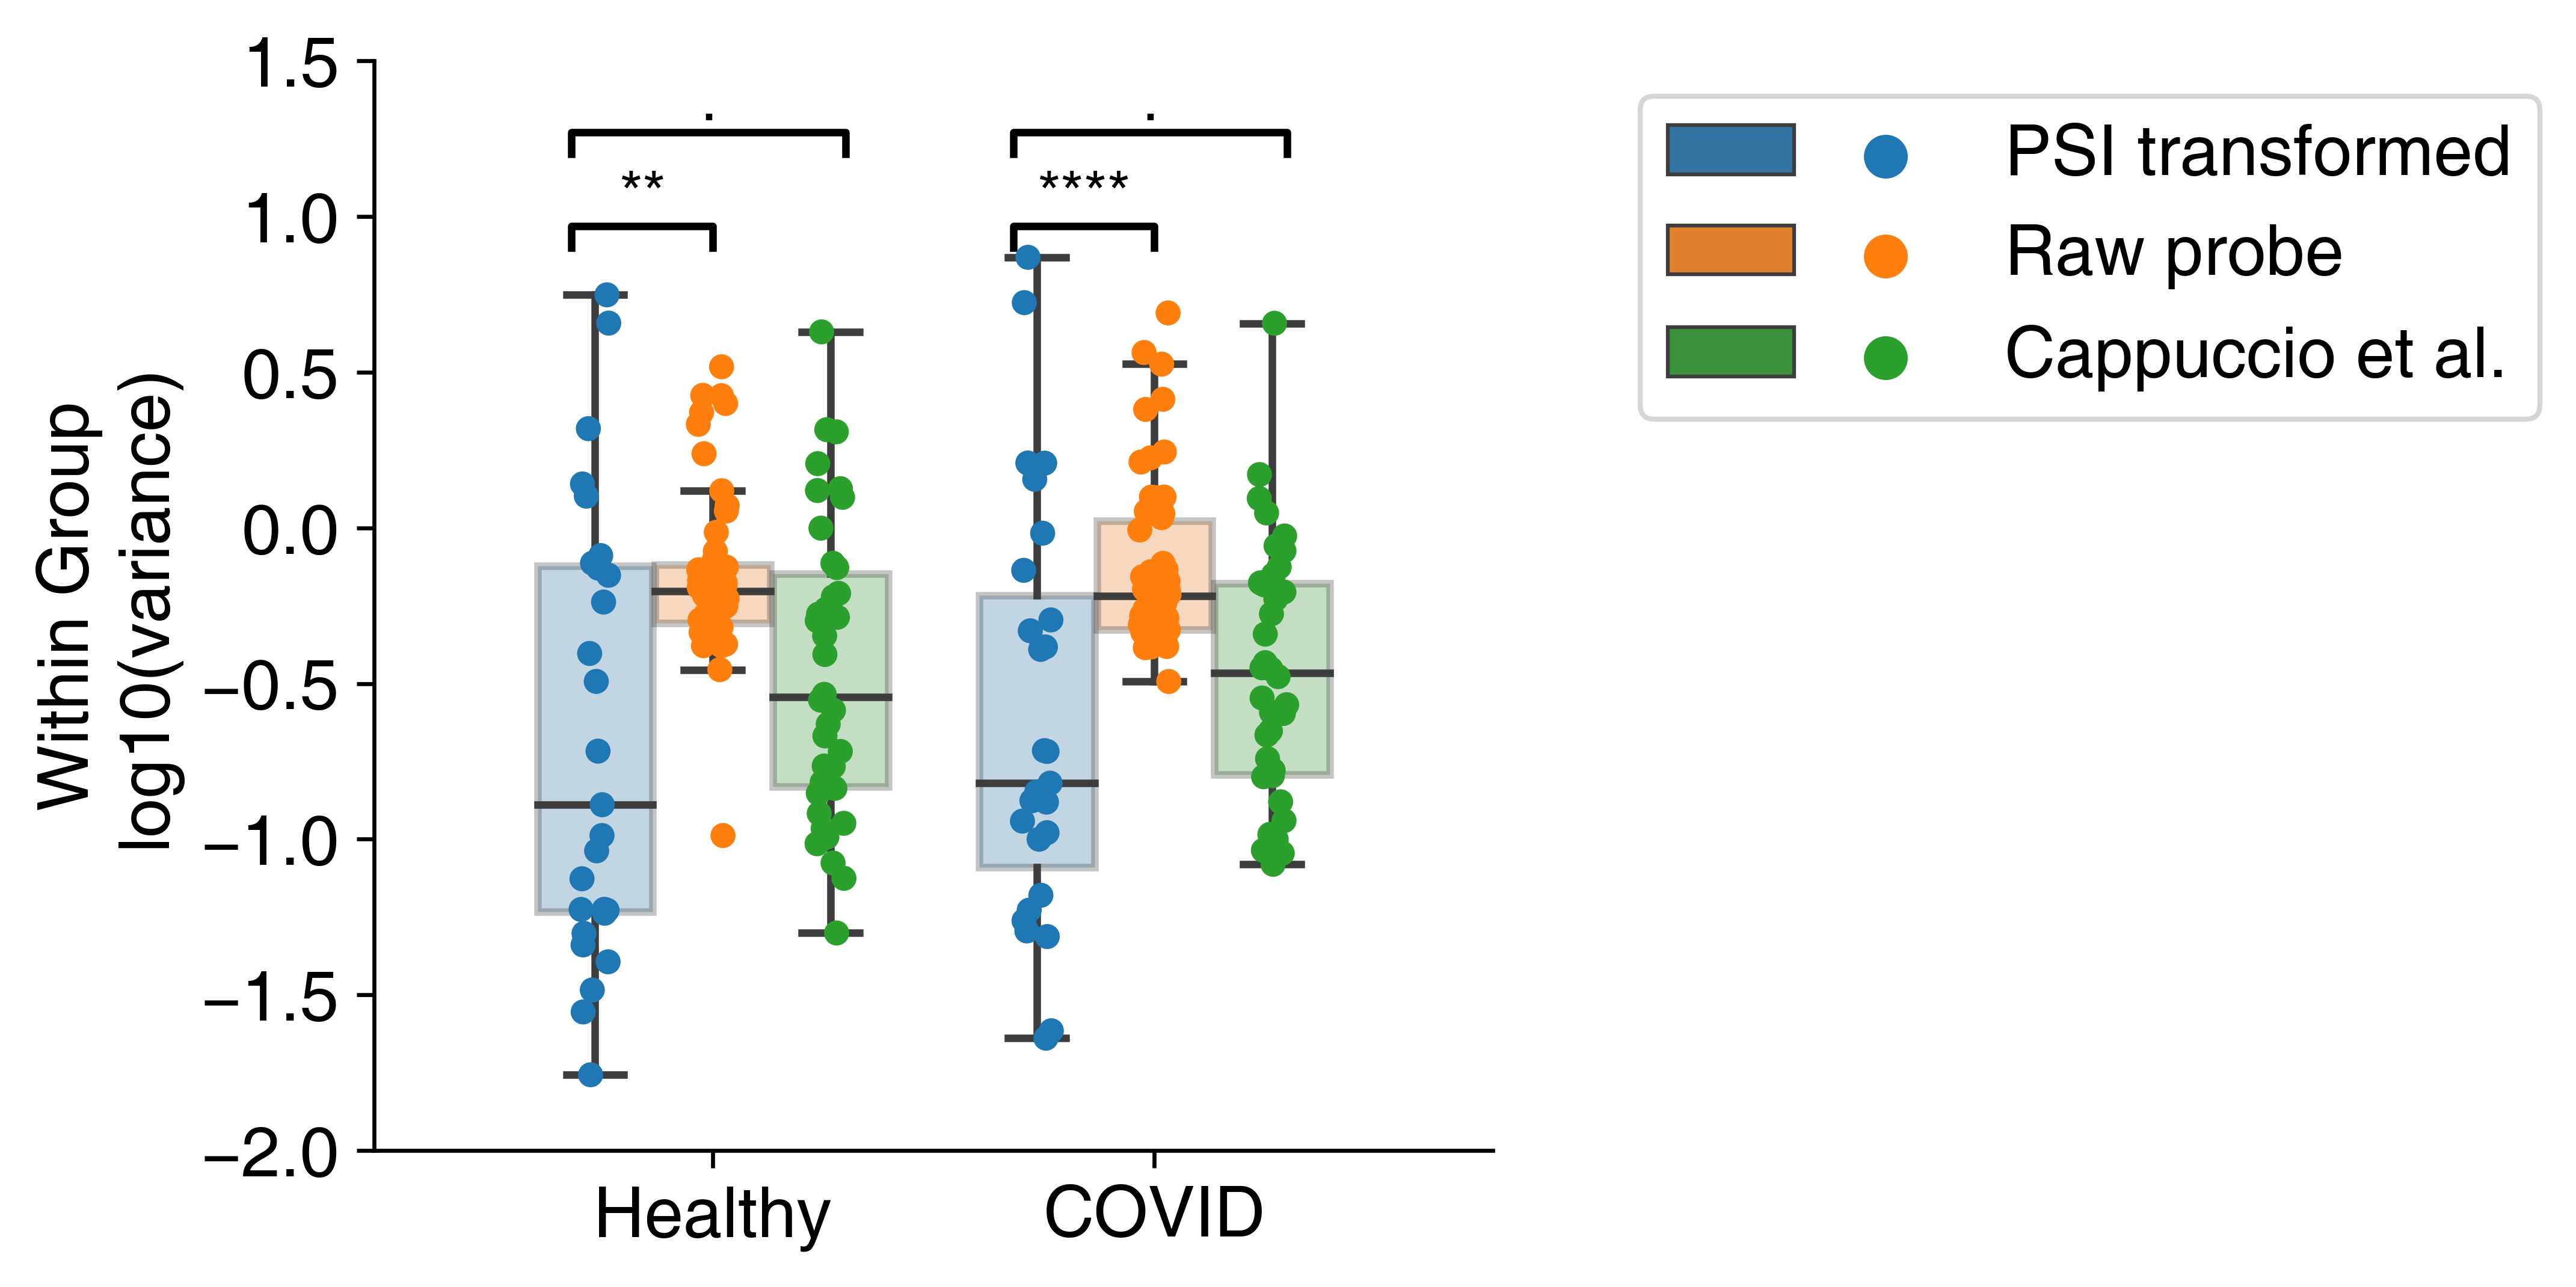

In [27]:
ax = sns.boxplot(x='group', y='log10_var', hue='measure', data=plot_df, showfliers=False, boxprops=dict(alpha=.3)
                )
sns.stripplot(x='group', y='log10_var', hue='measure', data=plot_df, dodge=True)
ax.legend(loc='top left', bbox_to_anchor=(1,1.05))
ax.set_ylim(-2, 1.5)
ax.set_ylabel('Within Group\nlog10(variance)')
ax.set_xlabel('')
#ax.set_yticklabels(['Healthy\n(p=%.1e)'%(t1.pvalue), 'COVID\n(p=%.1e)'%(t2.pvalue)])
plot_sig_stars(mhtdf.query('group=="Healthy"'), ax, 0.6, h=0.07)
plot_sig_stars(mhtdf.query('group=="COVID"'), ax, 0.6, h=0.07)



handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
  labels=['PSI transformed', 'Raw probe', 'Cappuccio et al.'],
  loc='upper left', bbox_to_anchor=(1.1, 1),
  handlelength=4,
  handler_map={tuple: HandlerTuple(ndivide=None)})


In [28]:
print("FINISH:", datetime.now())

FINISH: 2022-10-10 20:14:55.872890
